In [3]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widjets
%matplotlib inline

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm_notebook
import torchvision

import numpy as np
from utils import set_all_seeds
import warnings
warnings.filterwarnings('ignore')

# lock all seeds for reproducibility reasons
set_all_seeds()

## Обучение DCGAN реализовано в main.py. За основу был взят репозиторий https://github.com/AKASHKADEL/dcgan-mnist (из-за сохранения гифки процесса обучения), и применены некоторые хаки из https://github.com/soumith/ganhacks
а именно:
1. смягчение меток (smoothed_labels).
2. реализована запись логов в tensorboard
3. сохранение модели (почему-то не было??)
4. изменена нормализация MNIST от честных (0.13, 0.35) на (0.5, 0.5), поскольку генератор может генерировать картинки со значениями (-1,1).
5. BCELoss() -> BCEwithlogits() (убрал из дискриминатора sigmoid layer). чуть быстрее учится
.gif процесса обучения лежит в 'results/fixed_noise/animated.gif'

In [4]:
# load generator
from models import Generator

G = Generator(outp_c=1, inp_c=100, ngf=32).cuda().eval()
G.load_state_dict(torch.load('results/checkpoints_1/generator_param.pth'))
1

1

# 2.1 

## Обучение "процедуры Е" напоминает процесс дистилляции модели. Сначала я генерирую рандомный вектор (h), получаю картинки из генератора для этого вектора (G(h)). Затем оптимизируем разницу (MSE) между картинками 'G(h)' и 'G(E(G(h))',  Градиент протекает сквозь залоченную модель G и "накапливается" в модели E.

In [5]:
#Procedure E model
class Feed_Forward_Net(nn.Module):
    def __init__(self, outp_c=100, inp_c=28*28, ngf=32):
        super(Feed_Forward_Net, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(inp_c, ngf*32),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Linear(ngf*32, outp_c)
        )

    def forward(self, input):
        input = input.view(input.shape[0], -1)
        output = self.network(input).view(input.shape[0], -1, 1, 1) # just for convenience
        return output

In [6]:
# Learning params
from torch.optim.lr_scheduler import OneCycleLR
from catalyst.contrib.nn import RAdam, Lookahead

batch_size = 64
latent_dim = G.network[0].in_channels # 100
num_epochs=5000

# model
E = Feed_Forward_Net().cuda().eval()
#RAdam + Lookahead rules!
base_optimizer = RAdam(E.parameters(), weight_decay=0.03) 
optimizer = Lookahead(base_optimizer) 
# criterion MSE. It can be BCE, or BCE+DICE, or L1Loss
criterion = nn.MSELoss()#nn.L1Loss()
# Cosine scheduler
scheduler = OneCycleLR(optimizer,max_lr=0.005, steps_per_epoch=1, epochs=num_epochs)

## Training

In [7]:
train_loss_hist = []
val_loss_hist = []
G.eval()
fixed_noise = torch.randn(batch_size, latent_dim, 1, 1).cuda()
fixed_images = G(fixed_noise).detach()

for epoch in tqdm_notebook(range(num_epochs)):
    E.train()
    latent_h = torch.randn(batch_size, latent_dim, 1, 1).cuda() # latent h
    inputs = G(latent_h).detach() # G(h)

    optimizer.zero_grad()
    outputs = G(E(inputs)) # G(E(G(h))
    
    loss = criterion(outputs, inputs) #MSE
    loss.backward()
    optimizer.step()
    scheduler.step()
    
    # statistics
    E.eval()
    E_images = G(E(fixed_images))
    images_diff = nn.functional.mse_loss(fixed_images, E_images).item()
    val_loss_hist.append(images_diff)
    train_loss_hist.append(loss.item())

print('Finished Training')


Finished Training


## Графики свидетельствуют что обучение сошлось

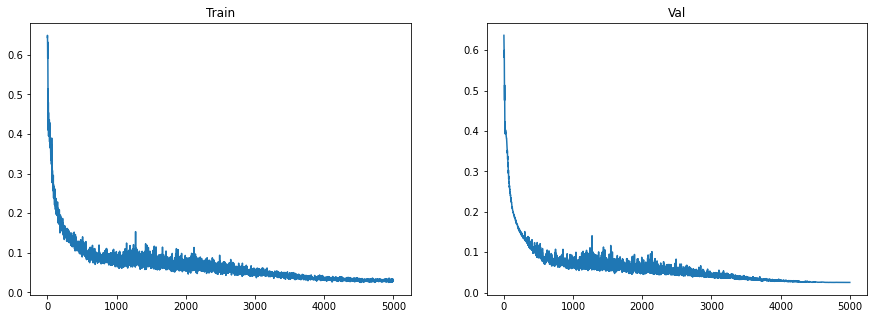

In [8]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(train_loss_hist)
plt.title('Train')

plt.subplot(1,2,2)
plt.plot(val_loss_hist)
plt.title('Val')

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MSE( G(h), G(E(G(h))) ) = 0.03215262293815613


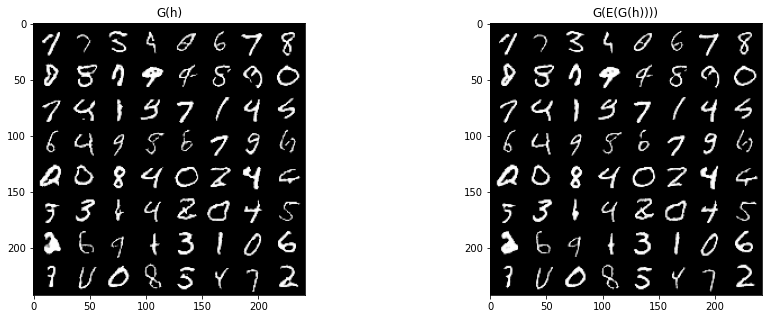

In [9]:
E.eval(), G.eval()

latent_h = torch.randn(batch_size, latent_dim, 1, 1).cuda() # h
G_images = G(latent_h).detach() # G(h)
G_E_images = G(E(G_images)) # G(E(G(h)))

MSE = nn.functional.mse_loss(G_images, G_E_images).item()
print('MSE( G(h), G(E(G(h))) ) =', MSE)

# placing images to grid for convenience
grid_G = torchvision.utils.make_grid(G_images.cpu())
grid_E = torchvision.utils.make_grid(G_E_images.cpu())

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title('G(h)')
plt.imshow(grid_G.permute(1,2,0))

plt.subplot(1,2,2)
plt.title('G(E(G(h))))')
plt.imshow(grid_E.permute(1,2,0))

## Изображения практически совпадают, MSE=0.025

# 2.2

для оптимизационного поиска вектора 'h' для картинки 'x':
1. генерируем начальное приближение вектора h - h_init
2. итеративно оптимизируем лосс между x и G(h). В качестве лосса я взял BCE+DICE - MSELoss гораздо хуже работает на очень тонких цифрах
3. вместо прямого SGD, использую RAdam оптимизатор и Scheduler.

In [10]:
def dice_loss(pred, target, eps=1.):
    pred = pred.contiguous()
    target = target.contiguous()

    intersection = (pred * target).sum(dim=2).sum(dim=2)

    loss = (1 - ((2. * intersection + eps) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + eps)))

    return loss.mean()

def calc_loss(pred, target, bce_weight=0.5):
    pred, target = pred.sigmoid(), target.sigmoid()
    #bce = F.binary_cross_entropy_with_logits(pred, target)
    bce = F.binary_cross_entropy(pred, target)
    dice = dice_loss(pred, target)
    loss = bce * bce_weight + dice * (1 - bce_weight)
    
    return loss

In [11]:
def find_h(x, G, max_epoch=4000):
    """
    :param x: torch.Tensor [1,n,1,1], real image
    :param G: nn.Module, Generator model
    :param max_epoch: int, maximum epoch for training
    
    Returns: dict{'loss_hist', 'h_init', 'h'}
    """
    
    G.eval()
    criterion = calc_loss
#     criterion = nn.MSELoss()
    # генерация начального вектора h
    latent_dim = G.network[0].in_channels
    h_init = torch.randn(1, latent_dim, 1, 1, requires_grad=False, device="cuda")#.cuda()
    
    # клонируем вектор, чтобы не изменять начальный. Его мы и будем оптимизировать
    h_latent = h_init.clone().requires_grad_() # not to change h_init
    
    # оптимайзеры
    optimizer = RAdam([h_latent], weight_decay=0.03) #RAdam rules
    scheduler = OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=1, epochs=max_epoch)
    
    # главный цикл
    loss_hist = []
    for ep in tqdm_notebook(range(num_epochs)):
        optimizer.zero_grad()
        outp = G(h_latent)
        loss = criterion(outp, x)
        loss.backward()
        optimizer.step()

        # Early stopping
        curr_loss = loss.item()
        if ep > 600:
            if abs(loss_hist[-100]-curr_loss)<0.0005:
                break        
        loss_hist.append(curr_loss)
    
    print('training finished')
    return {'loss_hist': loss_hist,
           'h_init': h_init,
           'h':h_latent}

In [12]:
# importing MNIST loader
from utils import get_data_loader
DS = get_data_loader(16)
# getting batch
batch = next(iter(DS))
x = batch[0][0].unsqueeze(0).cuda() # Real image


training finished


Text(0.5, 1.0, 'G(h) - image from optimized h')

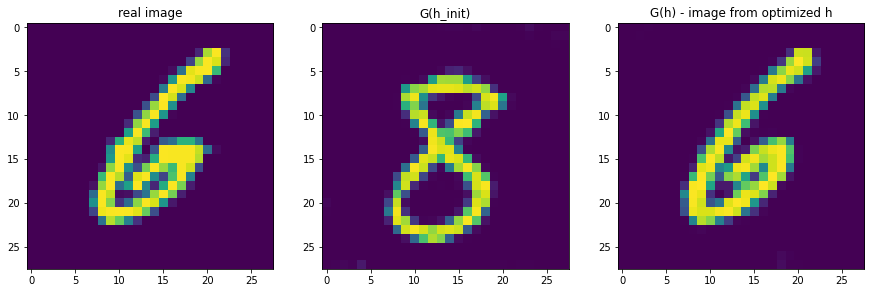

In [13]:
Dict = find_h(x, G, max_epoch=4000)

with torch.no_grad():
    real_image = x[0][0].cpu()
    h_init_image = G(Dict['h_init'])[0][0].cpu()
    image_from_h = G(Dict['h'])[0][0].cpu()

plt.figure(figsize=(15,10))
plt.subplot(1,3,1)
plt.imshow(real_image)
plt.title('real image')

plt.subplot(1,3,2)
plt.imshow(h_init_image)
plt.title('G(h_init)')

plt.subplot(1,3,3)
plt.imshow(image_from_h)
plt.title('G(h) - image from optimized h')



### Как видно, из начального приближения h_init получился вектор h, для которого G(h)~x

## Для улучшения генератора я бы поучил Conditional GAN, или лучше VAE.
## Для усиления "процедуры Е" я бы добавил в оптимизируемый лосс классовую компоненту:
1. взять предобученный классификатор на MNIST 'Classif'
2. добавить в лосс компоненту BCE(Classif(G(h)), Classif(x)).